<Figure size 640x480 with 0 Axes>

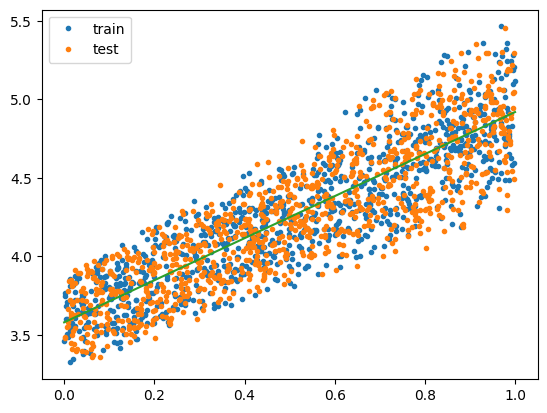

<Figure size 640x480 with 0 Axes>

In [3]:
a_const = 1.34
sigma_a = 0.4
b_const = 3.58
sigma_b = 0.3

n_samples = 1000

x_train = np.random.uniform(0, 1, n_samples)
y_train = x_train * np.random.uniform(a_const - sigma_a, a_const + sigma_a, n_samples) + np.random.uniform(b_const - sigma_b, b_const + sigma_b, n_samples)
x_test = np.random.uniform(0, 1, n_samples)
y_test = x_test * np.random.uniform(a_const - sigma_a, a_const + sigma_a, n_samples) + np.random.uniform(b_const - sigma_b, b_const + sigma_b, n_samples)


plt.plot(x_train, y_train, '.', label='train')
plt.plot(x_test, y_test, '.', label='test')
plt.plot([0, 1], [b_const, a_const + b_const])
plt.legend()
plt.figure()

In [4]:
def plot_evolution(history):
    plt.figure()

    cmap = plt.get_cmap('autumn', len(history))

    for i, step in enumerate(history):
        plt.scatter(*np.array(step['instances']).transpose(), marker='.', color=cmap(i))
        plt.xlabel('a')
        plt.ylabel('b')
        
    plt.scatter(a_const, b_const, s=10, c='k')


In [5]:
class Model:
    def __init__(self, processor, evaluator, selector, changer, parameters_shape):
        self.processor = processor
        self.evaluator = evaluator
        self.selector = selector
        self.changer = changer
        self.parameters_shape = parameters_shape
        
    def train(self, processor_initial_parameters, data, epochs, exploration_rate=None, generation_max_size=None):
        memory = {}
        instances = [processor_initial_parameters]
        scores = [[inst, np.mean([self.evaluator(self.processor(x, inst), y) for x, y in data])] for inst in instances]
        history = [dict(
            epoch=0,
            instances=instances,
            scores=scores,
            best_score=sorted(scores, key=lambda item: item[1], reverse=True)[0][1]
        )]
        for epoch in tqdm(range(1, epochs+1)):
            step_history = dict(epoch=epoch)
            instances_generated = []
            for _ in range(exploration_rate):
                for inst in instances:
                    instances_generated_this, memory = self.changer(inst, memory)
                    instances_generated.append(instances_generated_this)
            instances_generated = np.array(instances_generated).reshape(-1, *np.array(processor_initial_parameters).shape)
            assert len(instances_generated.shape) == 2
            assert instances_generated.shape[1] == 2
            scores_generated = [[inst, np.mean([self.evaluator(self.processor(x, inst), y) for x, y in data])] for inst in instances_generated]
            instances, memory = self.selector(self.processor, self.evaluator, data, instances_generated, scores_generated, generation_max_size, memory)
            assert len(instances.shape) == 2
            assert instances.shape[1] == 2
            scores = [[inst, np.mean([self.evaluator(self.processor(x, inst), y) for x, y in data])] for inst in instances]
            memory = dict(
                epoch=epoch,
                mean_score=np.mean([s[1] for s in scores]),
                best_score=sorted(scores, key=lambda item: item[1], reverse=True)[0][1]
            )
                                              
            
            history.append(dict(
                epoch=epoch,
                instances=instances,
                instances_generated=instances_generated,
                scores_generated=scores_generated,
                scores=scores,
                best_score=sorted(scores, key=lambda item: item[1], reverse=True)[0][1]
            ))
            
        return instances[0], history
        


def natural_selection(processor, evaluator, data, instances, scores, generation_max_size, selector_memory):
    sorted_list = sorted(scores, key=lambda item: item[1], reverse=True)
    selected = sorted_list[:generation_max_size]
    return np.array([s[0] for s in selected]), selector_memory
    
def natural_selection_slowdown(processor, evaluator, data, instances, scores, generation_max_size, selector_memory):
    sorted_list = sorted(scores, key=lambda item: item[1], reverse=True)
    selected = sorted_list[:generation_max_size]
    return np.array([s[0] for s in selected]), selector_memory


model = Model(
    processor=lambda x, p: p[0]*x + p[1],
    evaluator=lambda z, y: -np.abs(z - y),
    selector=natural_selection,
    changer=lambda p, memory: [p + (np.random.rand(2) - 0.5) / memory.get('epoch', 1), memory],
    parameters_shape=(2)
)

  0%|          | 0/1000 [00:00<?, ?it/s]

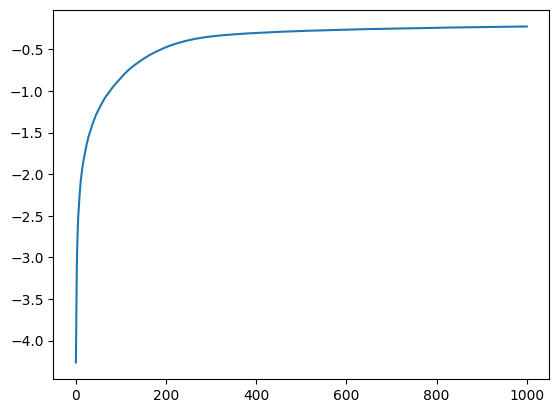

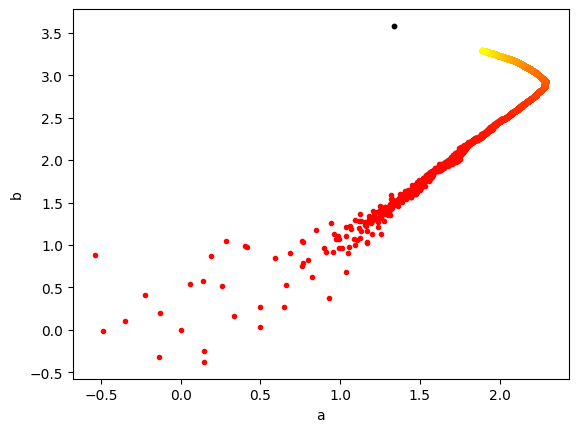

In [6]:
best_params, history = model.train([0, 0], np.transpose([x_train, y_train]), epochs=1000, exploration_rate=10, generation_max_size=10)
plt.plot([h['best_score'] for h in history])
plot_evolution(history)

In [7]:
def plot_selection(history):
    plt.figure()

    cmap = plt.get_cmap('autumn', len(history))

    for i, step in enumerate(history):
        if step.get('scores_generated') is None:
            continue
        try:

            plt.scatter(*np.array([sg[0] for sg in step['scores_generated']]).transpose(), marker='.', color=cmap(i))
            plt.xlabel('a')
            plt.ylabel('b')

            plt.scatter(a_const, b_const, s=10, c='k')
        except BaseException as e:
            print(*np.array([sg[0] for sg in step['scores_generated']]).transpose())
            raise e


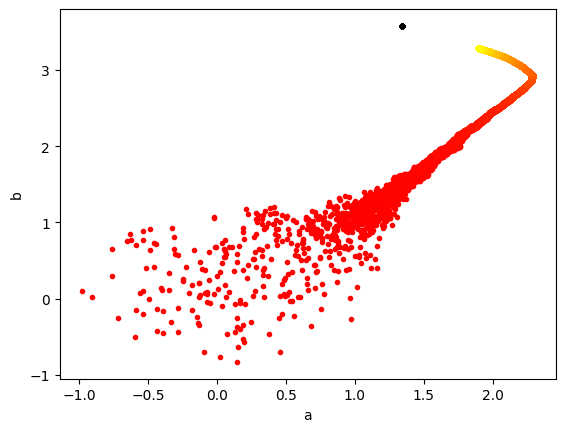

In [8]:
plot_selection(history)

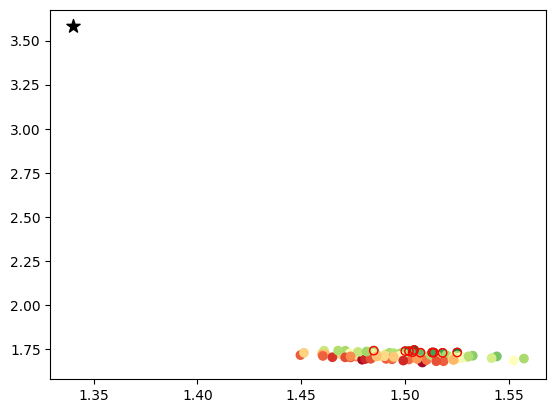

In [9]:
step = history[20]
sg = step['scores_generated']
px, py = np.array([a[0] for a in sg]).transpose()
scores = [a[1] for a in sg]
plt.scatter(px, py, c=scores, cmap=plt.get_cmap('RdYlGn'))

inst = step['instances']
px, py = np.array(inst).transpose()
plt.scatter(px, py, edgecolors='r', facecolors='none')

plt.scatter(a_const, b_const, s=100, c='k', marker='*')



In [10]:
def gradient_descent_squarediff_linear_regression(processor, evaluator, data, instances, scores, generation_max_size, selector_memory):
    '''
    assuming loss L = (y - (ax + b))**2
    '''
    list_L = []
    list_dLda = []
    list_dLdb = []
    a, b = instances[0]
    for x, y in data:
        list_L.append((a*x + b - y) * (a*x + b - y))
        list_dLda.append(2 * x * (a*x + b - y))
        list_dLdb.append(2 * (a*x + b - y))
    return np.array([[a - np.mean(list_dLda) / abs(a), b - np.mean(list_dLdb) / abs(b)]]), selector_memory
    

model_grad = Model(
    processor=lambda x, p: p[0]*x + p[1],
    evaluator=lambda z, y: -np.abs(z - y),
    selector=gradient_descent_squarediff_linear_regression,
    changer=lambda p, memory: [p + (np.random.rand(2) - 0.5) / memory.get('epoch', 1), memory],
    parameters_shape=(2)
)

  0%|          | 0/100 [00:00<?, ?it/s]

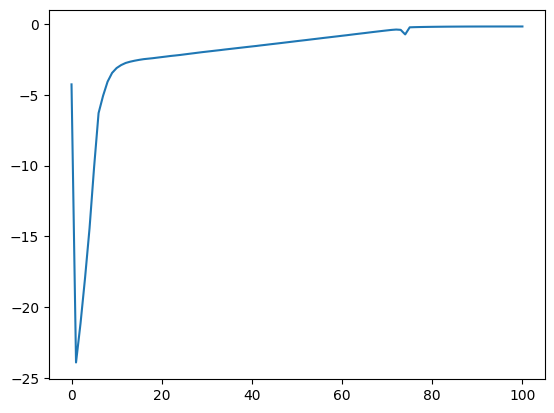

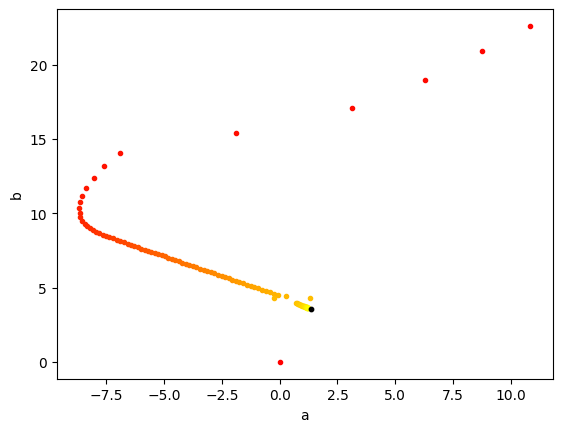

In [11]:
best_params_grad, history_grad = model_grad.train([0, 0], np.transpose([x_train, y_train]), epochs=100, exploration_rate=10, generation_max_size=10)
plt.plot([h['best_score'] for h in history_grad])
plot_evolution(history_grad)

In [14]:
history_grad[-1]

{'epoch': 100,
 'instances': array([[1.20823762, 3.65060629]]),
 'instances_generated': array([[1.20398916, 3.65591417],
        [1.20727209, 3.65523566],
        [1.20467412, 3.65436568],
        [1.20903929, 3.65377236],
        [1.20440408, 3.65344111],
        [1.20199091, 3.6576728 ],
        [1.20104871, 3.65644218],
        [1.20850879, 3.64797002],
        [1.20653158, 3.65703236],
        [1.20148029, 3.65303079]]),
 'scores_generated': [[array([1.20398916, 3.65591417]), -0.17288724092869356],
  [array([1.20727209, 3.65523566]), -0.17289152132195043],
  [array([1.20467412, 3.65436568]), -0.1728320032738211],
  [array([1.20903929, 3.65377236]), -0.17284867455987368],
  [array([1.20440408, 3.65344111]), -0.17279905979059174],
  [array([1.20199091, 3.6576728 ]), -0.17293921993547207],
  [array([1.20104871, 3.65644218]), -0.17288242953369365],
  [array([1.20850879, 3.64797002]), -0.17266277304197222],
  [array([1.20653158, 3.65703236]), -0.1729668376876744],
  [array([1.20148029, 

In [12]:
a_const, b_const

(1.34, 3.58)